In [1]:
import os
import pickle
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm


def find_image_dir():
    base_input = '/kaggle/input/datasets/adityajn105/flickr30k/Images'
    
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None


class FlickrDataset(Dataset):
   
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name


def main():
    IMAGE_DIR = find_image_dir()
    OUTPUT_FILE = '/kaggle/working/flickr30k_features.pkl'
    
    if IMAGE_DIR:
        print(f"✓ Found images at: {IMAGE_DIR}")
    else:
        raise FileNotFoundError(
            "Could not find the Flickr30k image directory. "
            "Please ensure the dataset is added to the notebook."
        )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model = nn.Sequential(*list(model.children())[:-1])
    model = nn.DataParallel(model).to(device)
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    dataset = FlickrDataset(IMAGE_DIR, transform)
    loader = DataLoader(dataset, batch_size=128, num_workers=4, pin_memory=True)
    
    print(f"Total images to process: {len(dataset)}")
    
    features_dict = {}
    with torch.no_grad():
        for imgs, names in tqdm(loader, desc="Extracting Features"):
            feats = model(imgs.to(device)).view(imgs.size(0), -1)
            
            for i, name in enumerate(names):
                features_dict[name] = feats[i].cpu().numpy()
    
    with open(OUTPUT_FILE, 'wb') as f:
        pickle.dump(features_dict, f)
    
    print(f"\n✓ Success! {len(features_dict)} images processed")
    print(f"✓ Features saved to {OUTPUT_FILE}")
    print(f"✓ Feature shape: {list(features_dict.values())[0].shape}")


if __name__ == "__main__":
    main()

✓ Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s] 


Total images to process: 31783


Extracting Features: 100%|██████████| 249/249 [01:52<00:00,  2.21it/s]



✓ Success! 31783 images processed
✓ Features saved to /kaggle/working/flickr30k_features.pkl
✓ Feature shape: (2048,)


In [2]:


import os
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import re


def find_captions_file():
   
    base_input = '/kaggle/input/datasets/adityajn105/flickr30k'
    
    for root, dirs, files in os.walk(base_input):
        if 'captions.txt' in files:
            return os.path.join(root, 'captions.txt')
    return None


class Vocabulary:
    
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = Counter()
        
        self.pad_token = "<pad>"
        self.start_token = "<start>"
        self.end_token = "<end>"
        self.unk_token = "<unk>"
        
        self.word2idx = {
            self.pad_token: 0,
            self.start_token: 1,
            self.end_token: 2,
            self.unk_token: 3
        }
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.idx = 4
    
    def build_vocabulary(self, captions_list):
        
        for caption in captions_list:
            tokens = self.tokenize(caption)
            self.word_freq.update(tokens)
        
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                if word not in self.word2idx:
                    self.word2idx[word] = self.idx
                    self.idx2word[self.idx] = word
                    self.idx += 1
        
        print(f"Vocabulary built with {len(self.word2idx)} unique tokens")
        print(f"Frequency threshold: {self.freq_threshold}")
    
    @staticmethod
    def tokenize(text):
       
        if text is None or pd.isna(text):
            return []
        
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text.split()
    
    def encode(self, text):
       
        tokens = self.tokenize(text)
        encoded = [self.word2idx[self.start_token]] 
        encoded += [self.word2idx.get(token, self.word2idx[self.unk_token]) for token in tokens]
        encoded.append(self.word2idx[self.end_token])
        return encoded
    
    def decode(self, indices):
        
        tokens = [self.idx2word.get(idx, self.unk_token) for idx in indices]
        tokens = [t for t in tokens if t not in [self.pad_token, self.start_token, self.end_token]]
        return ' '.join(tokens)
    
    def __len__(self):
        return len(self.word2idx)


def load_and_preprocess_captions(captions_file, features_file):

    df = pd.read_csv(captions_file)
    print(f"Loaded captions file with shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    with open(features_file, 'rb') as f:
        features_dict = pickle.load(f)
    
    available_images = set(features_dict.keys())
    print(f"Available image features: {len(available_images)}")
    
    image_captions = {}
    
    image_col = 'image' if 'image' in df.columns else df.columns[0]
    caption_col = 'caption' if 'caption' in df.columns else df.columns[1]
    
    skipped = 0
    for idx, row in df.iterrows():
        img_name = row[image_col]
        caption = row[caption_col]
        
        if caption is None or pd.isna(caption):
            skipped += 1
            continue
        
        if img_name in available_images:
            if img_name not in image_captions:
                image_captions[img_name] = []
            image_captions[img_name].append(str(caption))
    
    print(f"Total images with captions: {len(image_captions)}")
    print(f"Skipped {skipped} NaN captions")
    
    return image_captions


def prepare_data(image_captions, vocab, train_split=0.8, val_split=0.1):
    
    all_images = list(image_captions.keys())
    np.random.seed(42)  
    np.random.shuffle(all_images)
    
    n_total = len(all_images)
    n_train = int(n_total * train_split)
    n_val = int(n_total * val_split)
    
    train_images = all_images[:n_train]
    val_images = all_images[n_train:n_train + n_val]
    test_images = all_images[n_train + n_val:]
    
    print(f"\nData split:")
    print(f"  Train: {len(train_images)} images")
    print(f"  Val:   {len(val_images)} images")
    print(f"  Test:  {len(test_images)} images")
    
    def create_dataset(image_list):
        data = []
        for img_name in image_list:
            for caption in image_captions[img_name]:
                encoded = vocab.encode(caption)
                data.append((img_name, encoded, caption))
        return data
    
    train_data = create_dataset(train_images)
    val_data = create_dataset(val_images)
    test_data = create_dataset(test_images)
    
    print(f"\nData instances:")
    print(f"  Train: {len(train_data)} instances")
    print(f"  Val:   {len(val_data)} instances")
    print(f"  Test:  {len(test_data)} instances")
    
    return train_data, val_data, test_data


def main():
    CAPTIONS_FILE = find_captions_file()
    FEATURES_FILE = '/kaggle/working/flickr30k_features.pkl'
    
    if CAPTIONS_FILE is None:
        raise FileNotFoundError("Could not find captions.txt")
    
    print(f"Found captions at: {CAPTIONS_FILE}")
    
    image_captions = load_and_preprocess_captions(CAPTIONS_FILE, FEATURES_FILE)
    
    all_captions = [cap for caps in image_captions.values() for cap in caps]
    vocab = Vocabulary(freq_threshold=5)
    vocab.build_vocabulary(all_captions)

    train_data, val_data, test_data = prepare_data(image_captions, vocab)
    
    save_data = {
        'vocab': vocab,
        'train_data': train_data,
        'val_data': val_data,
        'test_data': test_data,
        'image_captions': image_captions
    }
    
    with open('/kaggle/working/preprocessed_data.pkl', 'wb') as f:
        pickle.dump(save_data, f)
    
    print(f"\n✅ Preprocessed data saved to /kaggle/working/preprocessed_data.pkl")
    
    print("\n" + "=" * 70)
    print("SAMPLE DATA:")
    print("=" * 70)
    sample_img, sample_encoded, sample_original = train_data[0]
    print(f"Image: {sample_img}")
    print(f"Original caption: {sample_original}")
    print(f"Encoded: {sample_encoded}")
    print(f"Decoded: {vocab.decode(sample_encoded)}")


if __name__ == "__main__":
    main()


Found captions at: /kaggle/input/datasets/adityajn105/flickr30k/captions.txt
Loaded captions file with shape: (158915, 2)
Columns: ['image', 'caption']
Available image features: 31783
Total images with captions: 31783
Skipped 1 NaN captions
Vocabulary built with 7727 unique tokens
Frequency threshold: 5

Data split:
  Train: 25426 images
  Val:   3178 images
  Test:  3179 images

Data instances:
  Train: 127129 instances
  Val:   15890 instances
  Test:  15895 instances

✅ Preprocessed data saved to /kaggle/working/preprocessed_data.pkl

SAMPLE DATA:
Image: 3655176735.jpg
Original caption:  AN older woman appears to read from a children 's book in an indoor setting , while a seated gentleman in a service uniform looks on .
Encoded: [1, 73, 535, 156, 1182, 82, 341, 49, 31, 372, 125, 1428, 17, 73, 1756, 474, 14, 31, 657, 740, 17, 31, 2815, 254, 355, 52, 2]
Decoded: an older woman appears to read from a children s book in an indoor setting while a seated gentleman in a service uniform loo

Loading preprocessed data...
Loading image features...

Model Summary:
Vocabulary size: 7727
Total parameters: 8,568,111

STARTING TRAINING



Epoch 1 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.95it/s, loss=3.54] 



Epoch 1/15
Train Loss: 3.6781
Val Loss:   3.2240
✅ Best model saved!
------------------------------------------------------------


Epoch 2 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.92it/s, loss=3.36] 



Epoch 2/15
Train Loss: 3.0394
Val Loss:   3.0348
✅ Best model saved!
------------------------------------------------------------


Epoch 3 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.71it/s, loss=3.27] 



Epoch 3/15
Train Loss: 2.8314
Val Loss:   2.9669
✅ Best model saved!
------------------------------------------------------------


Epoch 4 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.14it/s, loss=3.33] 



Epoch 4/15
Train Loss: 2.6968
Val Loss:   2.9332
✅ Best model saved!
------------------------------------------------------------


Epoch 5 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.41it/s, loss=3.29] 



Epoch 5/15
Train Loss: 2.5948
Val Loss:   2.9245
✅ Best model saved!
------------------------------------------------------------


Epoch 6 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.59it/s, loss=3.19] 



Epoch 6/15
Train Loss: 2.5130
Val Loss:   2.9247
------------------------------------------------------------


Epoch 7 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.23it/s, loss=3.37] 



Epoch 7/15
Train Loss: 2.4447
Val Loss:   2.9363
------------------------------------------------------------


Epoch 8 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.73it/s, loss=3.24] 



Epoch 8/15
Train Loss: 2.3853
Val Loss:   2.9401
------------------------------------------------------------


Epoch 9 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.46it/s, loss=3.41] 



Epoch 9/15
Train Loss: 2.3331
Val Loss:   2.9474
------------------------------------------------------------


Epoch 10 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.68it/s, loss=3.31] 



Epoch 10/15
Train Loss: 2.1708
Val Loss:   2.9433
------------------------------------------------------------


Epoch 11 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.81it/s, loss=3.36] 



Epoch 11/15
Train Loss: 2.1199
Val Loss:   2.9647
------------------------------------------------------------


Epoch 12 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.13it/s, loss=3.4]  



Epoch 12/15
Train Loss: 2.0822
Val Loss:   2.9840
------------------------------------------------------------


Epoch 13 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.55it/s, loss=3.35] 



Epoch 13/15
Train Loss: 2.0482
Val Loss:   3.0043
------------------------------------------------------------


Epoch 14 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.46it/s, loss=3.47] 



Epoch 14/15
Train Loss: 1.9423
Val Loss:   3.0195
------------------------------------------------------------


Epoch 15 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.12it/s, loss=3.47] 



Epoch 15/15
Train Loss: 1.9134
Val Loss:   3.0346
------------------------------------------------------------


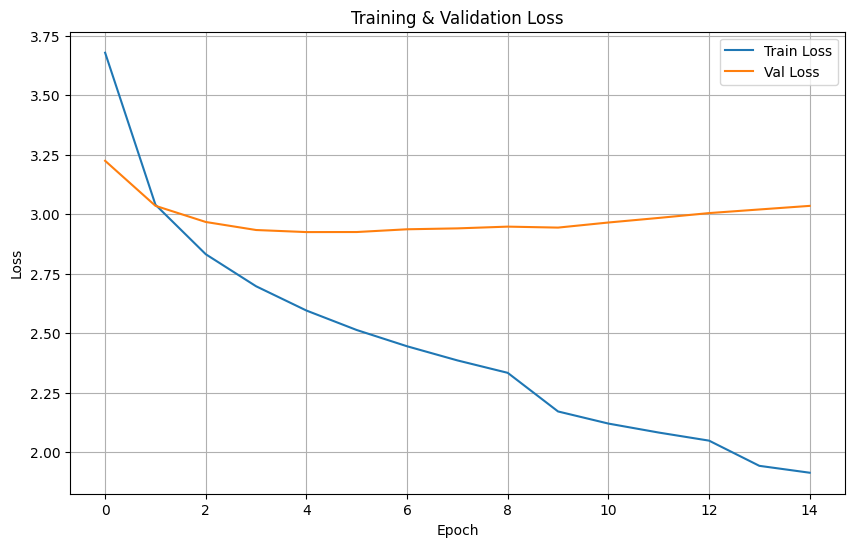


✅ TRAINING COMPLETE!
✅ Best model saved to: /kaggle/working/best_model.pth


In [3]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, feature_size=2048, embed_size=256, hidden_size=512, num_layers=1):
        super(ImageCaptioningModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.feature_fc = nn.Linear(feature_size, hidden_size)
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        
        hidden = torch.tanh(self.feature_fc(features))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        
        cell = torch.zeros_like(hidden)
        
        embeddings = self.embedding(captions)
        
        lstm_out, _ = self.lstm(embeddings, (hidden, cell))
        
        outputs = self.fc_out(lstm_out)
        
        return outputs
    
    def generate_caption(self, features, start_token, end_token, max_len=20):
        
        batch_size = features.size(0)
        device = features.device
        
        hidden = torch.tanh(self.feature_fc(features))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)
        
        inputs = torch.tensor([[start_token]] * batch_size, device=device)
        
        caption_ids = []
        
        for step in range(max_len):
            embed = self.embedding(inputs)
            lstm_out, (hidden, cell) = self.lstm(embed, (hidden, cell))
            output = self.fc_out(lstm_out.squeeze(1))
            
            predicted = output.argmax(1)
            caption_ids.append(predicted)
            
            if (predicted == end_token).all():
                break
            
            inputs = predicted.unsqueeze(1)
        
        caption_ids = torch.stack(caption_ids, dim=1)
        return caption_ids
    
    def beam_search(self, features, start_token, end_token, beam_width=3, max_len=20):
       
        device = features.device
        
        hidden = torch.tanh(self.feature_fc(features))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)
        
        sequences = [([start_token], 0.0, hidden.clone(), cell.clone())]
        
        for step in range(max_len):
            all_candidates = []
            
            for seq, score, h, c in sequences:
                if seq[-1] == end_token:
                    all_candidates.append((seq, score, h, c))
                    continue
                
                inp = torch.tensor([[seq[-1]]], device=device)
                emb = self.embedding(inp)
                
                out, (new_h, new_c) = self.lstm(emb, (h, c))
                logits = self.fc_out(out.squeeze(1))
                
                log_probs = torch.log_softmax(logits, dim=1)
                top_log_probs, top_idx = log_probs.topk(beam_width, dim=1)
                
                for i in range(beam_width):
                    token = top_idx[0][i].item()
                    token_score = top_log_probs[0][i].item()
                    
                    candidate = (
                        seq + [token],
                        score + token_score,
                        new_h.clone(),
                        new_c.clone()
                    )
                    all_candidates.append(candidate)
            
            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
            
            if all(seq[0][-1] == end_token for seq in sequences):
                break
        
        best_seq = sequences[0][0]
        return best_seq


class CaptionDataset(Dataset):
    def __init__(self, data, features_dict, vocab):
        self.data = data
        self.features_dict = features_dict
        self.vocab = vocab
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name, caption_indices, _ = self.data[idx]
        
        features = self.features_dict[img_name]
        features = torch.FloatTensor(features)
        
        caption = torch.LongTensor(caption_indices)
        
        return features, caption, img_name


def collate_fn(batch):
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    
    features, captions, img_names = zip(*batch)
    
    features = torch.stack(features, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=0)
    
    return features, captions, img_names


class Trainer:
    def __init__(self, model, train_loader, val_loader, vocab, device, config):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.vocab = vocab
        self.device = device
        self.config = config
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad_token])
        
        self.optimizer = optim.Adam(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config.get('weight_decay', 0)
        )
        
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=3
        )
        
        self.train_losses = []
        self.val_losses = []
    
    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1} [Train]")
        
        for features, captions, _ in pbar:
            features = features.to(self.device)
            captions = captions.to(self.device)
            
            caption_input = captions[:, :-1]
            caption_target = captions[:, 1:]
            
            outputs = self.model(features, caption_input)
            
            outputs = outputs.reshape(-1, outputs.size(2))
            caption_target = caption_target.reshape(-1)
            
            loss = self.criterion(outputs, caption_target)
            
            self.optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})
        
        return total_loss / len(self.train_loader)
    
    def validate(self, epoch):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc=f"Epoch {epoch+1} [Val]")
            
            for features, captions, _ in pbar:
                features = features.to(self.device)
                captions = captions.to(self.device)
                
                caption_input = captions[:, :-1]
                caption_target = captions[:, 1:]
                
                outputs = self.model(features, caption_input)
                
                outputs = outputs.reshape(-1, outputs.size(2))
                caption_target = caption_target.reshape(-1)
                
                loss = self.criterion(outputs, caption_target)
                
                total_loss += loss.item()
                pbar.set_postfix({"loss": loss.item()})
        
        return total_loss / len(self.val_loader)
    
    def train(self, num_epochs):
        best_val_loss = float("inf")
        
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(epoch)
            val_loss = self.validate(epoch)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            self.scheduler.step(val_loss)
            
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss:   {val_loss:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), "/kaggle/working/best_model.pth")
                print("✅ Best model saved!")
            
            print("-" * 60)
        
        return self.train_losses, self.val_losses
    
    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training & Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.savefig("/kaggle/working/loss_curve.png", dpi=300)
        plt.show()

def main():
    print("Loading preprocessed data...")
    with open("/kaggle/working/preprocessed_data.pkl", "rb") as f:
        data = pickle.load(f)
    
    vocab = data["vocab"]
    train_data = data["train_data"]
    val_data = data["val_data"]
    
    print("Loading image features...")
    with open("/kaggle/working/flickr30k_features.pkl", "rb") as f:
        features_dict = pickle.load(f)
    
    train_dataset = CaptionDataset(train_data, features_dict, vocab)
    val_dataset = CaptionDataset(val_data, features_dict, vocab)
    
    config = {
        "batch_size": 64,
        "learning_rate": 0.001,
        "weight_decay": 1e-5,
        "num_epochs": 15,
        "embed_size": 256,
        "hidden_size": 512,
        "num_layers": 1
    }
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = ImageCaptioningModel(
        vocab_size=len(vocab),
        feature_size=2048,
        embed_size=config["embed_size"],
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"]
    )
    
    print("\nModel Summary:")
    print(f"Vocabulary size: {len(vocab)}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    trainer = Trainer(model, train_loader, val_loader, vocab, device, config)
    
    print("\n" + "="*70)
    print("STARTING TRAINING")
    print("="*70 + "\n")
    
    trainer.train(config["num_epochs"])
    trainer.plot_losses()
    
    print("\n✅ TRAINING COMPLETE!")
    print(f"✅ Best model saved to: /kaggle/working/best_model.pth")


if __name__ == "__main__":
    main()

In [4]:
import torch
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from collections import Counter
from tqdm import tqdm

import torch.nn as nn

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, feature_size=2048, embed_size=256, hidden_size=512, num_layers=1):
        super(ImageCaptioningModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.feature_fc = nn.Linear(feature_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        hidden = torch.tanh(self.feature_fc(features))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)
        embeddings = self.embedding(captions)
        lstm_out, _ = self.lstm(embeddings, (hidden, cell))
        outputs = self.fc_out(lstm_out)
        return outputs
    
    def generate_caption(self, features, start_token, end_token, max_len=20):

        batch_size = features.size(0)
        device = features.device
        
        hidden = torch.tanh(self.feature_fc(features))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)
        
        inputs = torch.tensor([[start_token]] * batch_size, device=device)
        caption_ids = []
        
        for step in range(max_len):
            embed = self.embedding(inputs)
            lstm_out, (hidden, cell) = self.lstm(embed, (hidden, cell))
            output = self.fc_out(lstm_out.squeeze(1))
            
            predicted = output.argmax(1)
            caption_ids.append(predicted)
            
            if (predicted == end_token).all():
                break
            
            inputs = predicted.unsqueeze(1)
        
        caption_ids = torch.stack(caption_ids, dim=1)
        return caption_ids
    
    def beam_search(self, features, start_token, end_token, beam_width=3, max_len=20):
     
        device = features.device
        
        hidden = torch.tanh(self.feature_fc(features))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)
        
        sequences = [([start_token], 0.0, hidden.clone(), cell.clone())]
        
        for step in range(max_len):
            all_candidates = []
            
            for seq, score, h, c in sequences:
                if seq[-1] == end_token:
                    all_candidates.append((seq, score, h, c))
                    continue
                
                inp = torch.tensor([[seq[-1]]], device=device)
                emb = self.embedding(inp)
                out, (new_h, new_c) = self.lstm(emb, (h, c))
                logits = self.fc_out(out.squeeze(1))
                
                log_probs = torch.log_softmax(logits, dim=1)
                top_log_probs, top_idx = log_probs.topk(beam_width, dim=1)
                
                for i in range(beam_width):
                    token = top_idx[0][i].item()
                    token_score = top_log_probs[0][i].item()
                    candidate = (
                        seq + [token],
                        score + token_score,
                        new_h.clone(),
                        new_c.clone()
                    )
                    all_candidates.append(candidate)
            
            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
            
            if all(seq[0][-1] == end_token for seq in sequences):
                break
        
        return sequences[0][0]


class CaptionGenerator:
    def __init__(self, model_path, preprocessed_data_path, features_path, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        print("Loading preprocessed data...")
        with open(preprocessed_data_path, 'rb') as f:
            data = pickle.load(f)
        
        self.vocab = data['vocab']
        self.test_data = data['test_data']
        
        print("Loading image features...")
        with open(features_path, 'rb') as f:
            self.features_dict = pickle.load(f)
        
        print("Loading trained model...")
        self.model = ImageCaptioningModel(
            vocab_size=len(self.vocab),
            feature_size=2048,
            embed_size=256,
            hidden_size=512,
            num_layers=1
        )
        
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        
        print(f"✓ Model loaded on {self.device}")
        print(f"✓ Vocabulary size: {len(self.vocab)}")
        print(f"✓ Test images: {len(set(img for img, _, _ in self.test_data))}")
    
    def generate_caption_greedy(self, img_name):
        if img_name not in self.features_dict:
            return "Image features not found"
        
        features = torch.FloatTensor(self.features_dict[img_name]).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            caption_ids = self.model.generate_caption(
                features,
                start_token=self.vocab.word2idx[self.vocab.start_token],
                end_token=self.vocab.word2idx[self.vocab.end_token],
                max_len=20
            )
        
        caption_ids = caption_ids[0].cpu().numpy()
        caption = self.vocab.decode(caption_ids)
        
        return caption
    
    def generate_caption_beam(self, img_name, beam_width=3):
        if img_name not in self.features_dict:
            return "Image features not found"
        
        features = torch.FloatTensor(self.features_dict[img_name]).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            caption_ids = self.model.beam_search(
                features,
                start_token=self.vocab.word2idx[self.vocab.start_token],
                end_token=self.vocab.word2idx[self.vocab.end_token],
                beam_width=beam_width,
                max_len=20
            )
        
        caption = self.vocab.decode(caption_ids)
        return caption
    
    def test_samples(self, num_samples=20, use_beam=False):
        test_images = {}
        for img_name, _, original_caption in self.test_data:
            if img_name not in test_images:
                test_images[img_name] = []
            test_images[img_name].append(original_caption)
        
        image_names = list(test_images.keys())[:num_samples]
        
        print("\n" + "="*80)
        print(f"Testing on {len(image_names)} images")
        print(f"Method: {'Beam Search (width=3)' if use_beam else 'Greedy Search'}")
        print("="*80 + "\n")
        
        for i, img_name in enumerate(image_names, 1):
            print(f"\n[{i}/{len(image_names)}] Image: {img_name}")
            print("-" * 80)
            
            if use_beam:
                generated = self.generate_caption_beam(img_name, beam_width=3)
            else:
                generated = self.generate_caption_greedy(img_name)
            
            print(f"Generated: {generated}")
            print(f"\nGround Truth:")
            for j, ref in enumerate(test_images[img_name][:3], 1):
                print(f"  {j}. {ref}")
    
    def visualize_predictions(self, image_dir, num_examples=10, use_beam=False):
        test_images = {}
        for img_name, _, original_caption in self.test_data:
            if img_name not in test_images:
                test_images[img_name] = []
            test_images[img_name].append(original_caption)
        
        image_names = list(test_images.keys())[:num_examples]
        
        num_cols = 2
        num_rows = (num_examples + 1) // 2
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
        axes = axes.flatten() if num_examples > 1 else [axes]
        
        for idx, (img_name, ax) in enumerate(zip(image_names, axes)):
            img_path = os.path.join(image_dir, img_name)
            
            if os.path.exists(img_path):
                img = Image.open(img_path)
                ax.imshow(img)
            ax.axis('off')
            
            if use_beam:
                generated = self.generate_caption_beam(img_name, beam_width=3)
            else:
                generated = self.generate_caption_greedy(img_name)
            
            title = f"Generated: {generated}\n\nGround Truth:\n"
            for i, ref in enumerate(test_images[img_name][:2], 1):
                title += f"{i}. {ref}\n"
            
            ax.set_title(title, fontsize=9, loc='left', wrap=True)
        
        for idx in range(len(image_names), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        
        method = "beam" if use_beam else "greedy"
        filename = f"/kaggle/working/predictions_{method}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"\n✓ Saved predictions to: {filename}")
    
    def evaluate_diversity(self, num_samples=100):
        test_images = {}
        for img_name, _, _ in self.test_data:
            if img_name not in test_images:
                test_images[img_name] = True
        
        image_names = list(test_images.keys())[:num_samples]
        
        generated_captions = []
        
        print(f"\nGenerating captions for {len(image_names)} images to check diversity...")
        for img_name in tqdm(image_names):
            caption = self.generate_caption_greedy(img_name)
            generated_captions.append(caption)
        
        unique_captions = len(set(generated_captions))
        caption_counter = Counter(generated_captions)
        most_common = caption_counter.most_common(5)
        
        print("\n" + "="*80)
        print("DIVERSITY ANALYSIS")
        print("="*80)
        print(f"Total images tested: {len(image_names)}")
        print(f"Unique captions generated: {unique_captions}")
        print(f"Diversity ratio: {unique_captions/len(image_names)*100:.1f}%")
        print(f"\nMost common captions:")
        for caption, count in most_common:
            print(f"  [{count}x] {caption}")
        
        if unique_captions < len(image_names) * 0.3:
            print("\n  WARNING: Low diversity detected!")
            print("   The model may still have issues generating varied captions.")
        else:
            print("\n Good diversity! Model is generating varied captions.")


def main():
    MODEL_PATH = "/kaggle/working/best_model.pth"
    PREPROCESSED_DATA_PATH = "/kaggle/working/preprocessed_data.pkl"
    FEATURES_PATH = "/kaggle/working/flickr30k_features.pkl"
    IMAGE_DIR = "/kaggle/input/datasets/adityajn105/flickr30k/Images"
    
    image_dir_found = os.path.exists(IMAGE_DIR)
    if not image_dir_found:
        for root, dirs, files in os.walk("/kaggle/input"):
            if "Images" in dirs:
                IMAGE_DIR = os.path.join(root, "Images")
                image_dir_found = True
                break
    
    generator = CaptionGenerator(
        model_path=MODEL_PATH,
        preprocessed_data_path=PREPROCESSED_DATA_PATH,
        features_path=FEATURES_PATH
    )
    
    print("\n" + "="*80)
    print("CHECKING CAPTION DIVERSITY")
    print("="*80)
    generator.evaluate_diversity(num_samples=100)
    
    print("\n" + "="*80)
    print("GREEDY SEARCH RESULTS")
    print("="*80)
    generator.test_samples(num_samples=15, use_beam=False)
    
    print("\n\n" + "="*80)
    print("BEAM SEARCH RESULTS")
    print("="*80)
    generator.test_samples(num_samples=15, use_beam=True)
    
    if image_dir_found:
        print("\n" + "="*80)
        print("GENERATING VISUALIZATIONS")
        print("="*80)
        print(f"Using image directory: {IMAGE_DIR}")
        generator.visualize_predictions(IMAGE_DIR, num_examples=10, use_beam=False)
        generator.visualize_predictions(IMAGE_DIR, num_examples=10, use_beam=True)
    else:
        print("\n  Image directory not found. Skipping visualizations.")
    
    print("\n" + "="*80)
    print(" EVALUATION COMPLETE!")
    print("="*80)


if __name__ == "__main__":
    main()


Loading preprocessed data...
Loading image features...
Loading trained model...
✓ Model loaded on cuda
✓ Vocabulary size: 7727
✓ Test images: 3179

CHECKING CAPTION DIVERSITY

Generating captions for 100 images to check diversity...


100%|██████████| 100/100 [00:00<00:00, 142.57it/s]



DIVERSITY ANALYSIS
Total images tested: 100
Unique captions generated: 99
Diversity ratio: 99.0%

Most common captions:
  [2x] a man in a red shirt is playing a guitar
  [1x] a man in a yellow shirt and a woman in a yellow shirt are standing in front of a red
  [1x] a group of people are standing on a dock near a lake
  [1x] a man in a black jacket is standing on a sidewalk
  [1x] a young girl in a pink shirt is sitting on a chair and playing with a toy

 Good diversity! Model is generating varied captions.

GREEDY SEARCH RESULTS

Testing on 15 images
Method: Greedy Search


[1/15] Image: 463476205.jpg
--------------------------------------------------------------------------------
Generated: a man in a yellow shirt and a woman in a yellow shirt are standing in front of a red

Ground Truth:
  1.  A man on a motorcycle is riding in the street in the rain along with two green cabs and other vehicles .
  2.  A motorcycle and two green taxis are driving down the street in the rain .
  3. 

In [ ]:
import gradio as gr
import torch
import torch.nn as nn
import pickle
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models


class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, feature_size=2048, embed_size=256, hidden_size=512, num_layers=1):
        super(ImageCaptioningModel, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.feature_fc = nn.Linear(feature_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        hidden = torch.tanh(self.feature_fc(features))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)

        embeddings = self.embedding(captions)
        lstm_out, _ = self.lstm(embeddings, (hidden, cell))
        outputs = self.fc_out(lstm_out)

        return outputs

    def generate_caption(self, features, start_token, end_token, max_len=20):
        batch_size = features.size(0)
        device = features.device

        hidden = torch.tanh(self.feature_fc(features))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)

        inputs = torch.tensor([[start_token]] * batch_size, device=device)
        caption_ids = []

        for step in range(max_len):
            embed = self.embedding(inputs)
            lstm_out, (hidden, cell) = self.lstm(embed, (hidden, cell))
            output = self.fc_out(lstm_out.squeeze(1))

            predicted = output.argmax(1)
            caption_ids.append(predicted)

            if (predicted == end_token).all():
                break

            inputs = predicted.unsqueeze(1)

        caption_ids = torch.stack(caption_ids, dim=1)
        return caption_ids

    def beam_search(self, features, start_token, end_token, beam_width=3, max_len=20):
        device = features.device

        hidden = torch.tanh(self.feature_fc(features))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)

        sequences = [([start_token], 0.0, hidden.clone(), cell.clone())]

        for step in range(max_len):
            all_candidates = []

            for seq, score, h, c in sequences:
                if seq[-1] == end_token:
                    all_candidates.append((seq, score, h, c))
                    continue

                inp = torch.tensor([[seq[-1]]], device=device)
                emb = self.embedding(inp)
                out, (new_h, new_c) = self.lstm(emb, (h, c))
                logits = self.fc_out(out.squeeze(1))

                log_probs = torch.log_softmax(logits, dim=1)
                top_log_probs, top_idx = log_probs.topk(beam_width, dim=1)

                for i in range(beam_width):
                    token = top_idx[0][i].item()
                    token_score = top_log_probs[0][i].item()

                    candidate = (
                        seq + [token],
                        score + token_score,
                        new_h.clone(),
                        new_c.clone()
                    )
                    all_candidates.append(candidate)

            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

            if all(seq[0][-1] == end_token for seq in sequences):
                break

        return sequences[0][0]


class FeatureExtractor:
    def __init__(self, device):
        self.device = device

        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.feature_extractor.to(device)
        self.feature_extractor.eval()

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    def extract(self, image):
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            features = self.feature_extractor(img_tensor)
            features = features.view(features.size(0), -1)

        return features

class CaptionGeneratorApp:
    def __init__(self, model_path, preprocessed_data_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        print("Loading vocabulary...")
        with open(preprocessed_data_path, 'rb') as f:
            data = pickle.load(f)
        self.vocab = data['vocab']

        print("Loading caption model...")
        self.model = ImageCaptioningModel(
            vocab_size=len(self.vocab),
            feature_size=2048,
            embed_size=256,
            hidden_size=512,
            num_layers=1
        )

        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

        print("Loading feature extractor...")
        self.feature_extractor = FeatureExtractor(self.device)

        print(" App initialized successfully!")

    def generate_both_captions(self, image, beam_width=3):

        if image is None:
            return "Please upload an image", "Please upload an image"

        try:
            if not isinstance(image, Image.Image):
                image = Image.fromarray(image).convert("RGB")
            else:
                image = image.convert("RGB")

            # Extract features
            features = self.feature_extractor.extract(image)

            with torch.no_grad():
                greedy_ids = self.model.generate_caption(
                    features,
                    start_token=self.vocab.word2idx[self.vocab.start_token],
                    end_token=self.vocab.word2idx[self.vocab.end_token],
                    max_len=20
                )
                greedy_ids = greedy_ids[0].cpu().numpy()
                greedy_caption = self.vocab.decode(greedy_ids)

            with torch.no_grad():
                beam_ids = self.model.beam_search(
                    features,
                    start_token=self.vocab.word2idx[self.vocab.start_token],
                    end_token=self.vocab.word2idx[self.vocab.end_token],
                    beam_width=beam_width,
                    max_len=20
                )
                beam_caption = self.vocab.decode(beam_ids)

            return greedy_caption.capitalize() + ".", beam_caption.capitalize() + "."

        except Exception as e:
            return f"Error: {str(e)}", f"Error: {str(e)}"

def create_gradio_interface():
    MODEL_PATH = "/kaggle/working/best_model.pth"
    PREPROCESSED_DATA_PATH = "/kaggle/working/preprocessed_data.pkl"

    print("Initializing Caption Generator...")
    app = CaptionGeneratorApp(MODEL_PATH, PREPROCESSED_DATA_PATH)

    with gr.Blocks(title="Image Caption Generator", theme=gr.themes.Soft()) as demo:

        gr.Markdown("Image Caption Generator")
        gr.Markdown("This app generates captions using **Greedy Search** and **Beam Search**.")

        with gr.Row():
            with gr.Column(scale=1):
                image_input = gr.Image(
                    type="pil",
                    label="Upload Image",
                    height=400
                )

                beam_width = gr.Slider(
                    minimum=2,
                    maximum=5,
                    value=3,
                    step=1,
                    label="Beam Width (Beam Search)",
                    info="Higher beam width = better caption but slower"
                )

                with gr.Row():
                    generate_btn = gr.Button("Generate Captions", variant="primary", size="lg")
                    clear_btn = gr.ClearButton([image_input], value="Clear")

            with gr.Column(scale=1):
                greedy_output = gr.Textbox(
                    label="Greedy Caption",
                    placeholder="Greedy caption will appear here...",
                    lines=3
                )

                beam_output = gr.Textbox(
                    label="Beam Search Caption",
                    placeholder="Beam search caption will appear here...",
                    lines=3
                )

        generate_btn.click(
            fn=app.generate_both_captions,
            inputs=[image_input, beam_width],
            outputs=[greedy_output, beam_output]
        )

        image_input.change(
            fn=app.generate_both_captions,
            inputs=[image_input, beam_width],
            outputs=[greedy_output, beam_output]
        )

    return demo


def main():
    print("=" * 70)
    print("STARTING GRADIO IMAGE CAPTION GENERATOR")
    print("=" * 70)

    demo = create_gradio_interface()

    demo.launch(
        share=True,
        debug=True,
        show_error=True
    )


if __name__ == "__main__":
    main()


STARTING GRADIO IMAGE CAPTION GENERATOR
Initializing Caption Generator...
Using device: cuda
Loading vocabulary...
Loading caption model...
Loading feature extractor...
 App initialized successfully!
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://12b79ff8cd7aa4a47a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
